In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import spacy

In [61]:
#Spacy
nlp = spacy.load('de_core_news_sm')

#Read and format dataset
with open('tech_soft_none.json', 'r',encoding = 'utf8') as f:
    data = json.load(f)       
        
df = pd.DataFrame.from_dict(data["data"])

df.head(10)

,label,text
0,none,"Standort Trovarit AG München, Deutschland"
1,none,Wir freuen uns auf Ihre Bewerbung unter Angabe...
2,tech,Qualifikation zur Heimleitung gemäß Heimperson...
3,soft,Gute organisatorische und konzeptionelle Fähig...
4,soft,"Teamfähigkeit, hohe Flexibilität und Einsatzbe..."
5,soft,Überdurchschnittliche Einsatzbereitschaft
6,none,HomeIhre Karriere bei LeasePlanStellenangebote...
7,tech,Steuerkenntnisse sind sehr wünschenswert
8,soft,Kreativität und schnelle Auffassungsgabe
9,none,budget/forecast/prior year/prior month) and pr...


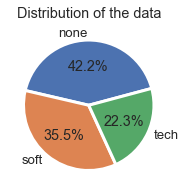

In [62]:
#Plot distribution of data
size = df.groupby("label").size().tolist()

_, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

plt.pie(size,labels = ["none","soft","tech"], 
        wedgeprops = {'linewidth': 3},
        autopct='%1.1f%%',
        startangle = 15)

ax.set_title("Distribution of the data")

plt.show()

In [63]:
from collections import Counter

#Get most common words for bag of words
alltext = ""
for d in df["text"]:
    alltext += d
doc = nlp(alltext)
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True 
         and token.like_num != True and token.pos_ != "SYM" and token.shape_[0:3].lower() == 'xxx']

word_freq = Counter(words)
common_words = word_freq.most_common(5000)
word_features = [t[0] for t in common_words]

In [64]:
#define feature vectors
def find_features(doc):
    words = doc
    features = []
    for w in word_features:
        features.append(1 if (w in words) else 0)
    return features

In [65]:
import numpy as np

#Extract feature vectors for each text entry with its corresponding label
featuresets = np.array([(find_features(df["text"][index]), df["label"][index]) for index,_ in df.iterrows()])

In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Prepare data for training
X = np.array([x[0] for x in featuresets[:]])
Y = [x[1] for x in featuresets[:]]

#Label Encoding
le = LabelEncoder().fit(Y)
Y = np.array(le.transform(Y))
    
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)



In [67]:
#Prediction with Multinomial Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

clf = MultinomialNB()
clf.fit(trainX, trainY)
accuaracy = clf.score(testX,testY)
print("Accuarcy: {0:.3%}".format(accuaracy))

Accuarcy: 92.236%


In [68]:
#Generae Confusion matrix to visualize data classification
from sklearn.metrics import plot_confusion_matrix

def plot_conf_mat(est,X,Y):
    disp = 0
    disp = plot_confusion_matrix(est, X, Y,
                                 display_labels = ["none","soft","tech"],
                                 cmap = plt.cm.Blues,
                                 normalize = "true")
    disp.ax_.set_title("Normalized confusion matrix")

    plt.show()

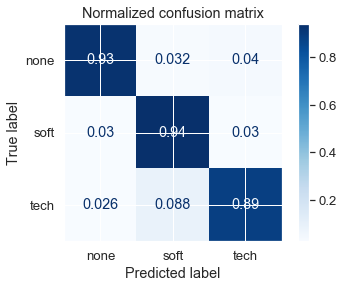

In [69]:
#Plot confusion matrix for this model
plot_conf_mat(clf,testX,testY)

Despite different train/test spliting ratios and word features selected, couldn't improve more than 95%


New model to train: Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression

#LogisticRegression model and training
clflr = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
clflr.fit(trainX, trainY)
accuaracy = clflr.score(testX,testY)

print("Accuarcy: {0:.3%}".format(accuaracy))

Accuarcy: 92.470%


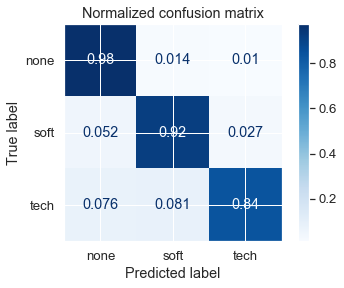

In [71]:
#Plot confusion matrix for this model
plot_conf_mat(clflr,testX,testY)

Bow let's try with a Neural Network (1-hidden-layer)

In [72]:
from sklearn.preprocessing import OneHotEncoder

#Prepare data for training
X = np.array([x[0] for x in featuresets[:]])
Y = [x[1] for x in featuresets[:]]

#One-hot-encoding
enc = OneHotEncoder(sparse = False)
Y = enc.fit_transform(np.array(Y).reshape(-1,1))
    
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

In [73]:
from keras.models import Sequential
from keras import layers
import tensorflow

input_dim = trainX.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(120, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 120)               600120    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 363       
Total params: 600,483
Trainable params: 600,483
Non-trainable params: 0
_________________________________________________________________


In [74]:
hist = model.fit(trainX, trainY,
                    verbose = 1,
                    epochs=15,
                    validation_data = (testX,testY),
                    batch_size=500)

Train on 7686 samples, validate on 2563 samples
Epoch 1/15
7686/7686 [==============================] - 2s 266us/step - loss: 0.9284 - accuracy: 0.8285 - val_loss: 0.7264 - val_accuracy: 0.9235
Epoch 2/15
7686/7686 [==============================] - 1s 98us/step - loss: 0.5887 - accuracy: 0.9320 - val_loss: 0.4684 - val_accuracy: 0.9333
Epoch 3/15
7686/7686 [==============================] - 1s 99us/step - loss: 0.3857 - accuracy: 0.9428 - val_loss: 0.3471 - val_accuracy: 0.9352
Epoch 4/15
7686/7686 [==============================] - 1s 99us/step - loss: 0.2828 - accuracy: 0.9512 - val_loss: 0.2880 - val_accuracy: 0.9391
Epoch 5/15
7686/7686 [==============================] - 1s 112us/step - loss: 0.2230 - accuracy: 0.9590 - val_loss: 0.2546 - val_accuracy: 0.9426
Epoch 6/15
7686/7686 [==============================] - 1s 110us/step - loss: 0.1839 - accuracy: 0.9649 - val_loss: 0.2347 - val_accuracy: 0.9434
Epoch 7/15
7686/7686 [==============================] - 1s 112us/step - loss: 0

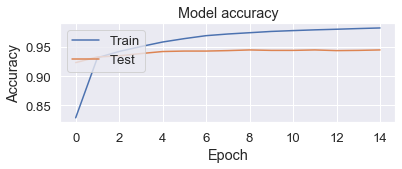

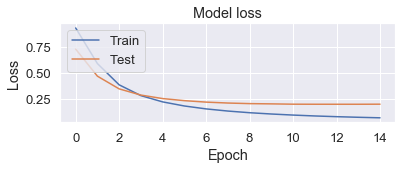

In [75]:
#history_dict = history.history
#history_dict.keys()

plt.subplot(2,1,1)
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(2,1,2)
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

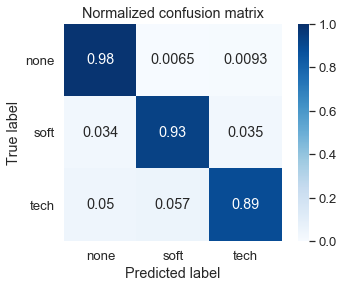

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Had to make the confusion matrix myself as I couldn0t use the previous one
sns.set()
cm=confusion_matrix(enc.inverse_transform(testY),enc.inverse_transform(model.predict(testX)))

row_sums = cm.sum(axis=1)
cm_norm = cm / row_sums[:, np.newaxis]

sns.set(font_scale=1.2)
ax = sns.heatmap(cm_norm, annot=True, vmin = 0, vmax = 1,
                cmap = plt.cm.Blues, square = True,
                xticklabels=["none","soft","tech"],
                yticklabels=["none","soft","tech"])

ax.set_title("Normalized confusion matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

In [77]:
#Just to check i'll use some personal Anschreiben texts 
#It's extra just for "fun"

rawData = "Für mich bedeutet die Zusammenarbeit mit Ihnen eine berufliche Koalition aneignen, wo ich mir eine so bekannte Arbeitskultur Ihres Unternehmen, und mit meiner gesammelten Erfahrung arbeiten kann"
newData = np.asarray(find_features(rawData))

newData = newData.reshape(1,-1)

predLabel = np.zeros(3)
predIndex = np.argmax(model.predict([newData]))
predLabel[predIndex] = 1

predLabel = predLabel.reshape(1,-1)

predLabelStr = enc.inverse_transform(predLabel)[0][0]

print(rawData + " =======> " + predLabelStr)


Für mich bedeutet die Zusammenarbeit mit Ihnen eine berufliche Koalition aneignen, wo ich mir eine so bekannte Arbeitskultur Ihres Unternehmen, und mit meiner gesammelten Erfahrung arbeiten kann =======> none


In [78]:
#Save current model trained model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [79]:
#Save vector of features
import pickle
with open('word_features', 'wb') as f:
    pickle.dump(word_features, f)